In [1]:
import random
import torch
import pickle
import os
import matplotlib.pyplot as plt

from collections import defaultdict

from causal_gym import AntMazePCH
from causal_rl.algo.imitation.imitate import *
from causal_rl.algo.imitation.finetune import *
from causal_rl.algo.imitation.gail.core_net import *
from causal_rl.algo.imitation.gail.causal_gail import *

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/et2842/miniconda3/envs/causalenv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
num_steps = 1000
seed = 0
lookback = 1
hidden_dims = {'O'}
train_eps = 300

random.seed(seed)
torch.manual_seed(seed)

In [4]:
expert_env = AntMazePCH(num_steps=num_steps, expert_mode=True, seed=seed)

In [5]:
env = AntMazePCH(num_steps=num_steps, seed=seed)

In [6]:
# to save time; conceptually the same
small_steps = lookback + 1
small_env = AntMazePCH(num_steps=small_steps, seed=seed)
G = parse_graph(small_env.get_graph)
X_small = {f'X{t}' for t in range(small_steps)}
Y = f'Y{small_steps}'

# G = parse_graph(env.get_graph)
X = {f'X{t}' for t in range(num_steps)}
# Y = f'Y{num_steps}'
obs_prefix = env.env.observed_unobserved_vars[0]

In [7]:
Z_sets = find_sequential_pi_backdoor(G, X_small, Y, obs_prefix)

base_step = small_steps - 1
base_Z_set = Z_sets[f'X{base_step}']

for i in range(base_step + 1, num_steps):
    updated_base_Z_set = set()
    for v in base_Z_set:
        updated_base_Z_set.add(f'{v[0]}{int(v[1:]) + i - lookback}')

    Z_sets[f'X{i}'] = updated_base_Z_set

Z_sets['X1']

{'A0', 'A1', 'J0', 'J1', 'L0', 'L1', 'P0', 'P1', 'T0', 'T1', 'X0'}

In [8]:
naive_Z_sets = {}
for Xi in X:
    i = int(Xi[1:])
    cond = set()

    for j in range(i+1):
        cond.update({f'{o}{j}' for o in list(set(obs_prefix) - {'X'})})

    for j in range(i):
        cond.add(f'X{j}')
    naive_Z_sets[Xi] = cond

naive_Z_sets['X1']

{'A0', 'A1', 'J0', 'J1', 'L0', 'L1', 'P0', 'P1', 'T0', 'T1', 'W0', 'W1', 'X0'}

In [9]:
# load expert
MODEL_PATH = '/home/et2842/causal/causalrl/models/antmaze_expert_finetuned.pt'
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)

# Rebuild the model with the same architecture
action_bounds = (checkpoint['action_bounds_low'], checkpoint['action_bounds_high'])

expert = ContinuousPolicyNN(
    input_dim=checkpoint['input_dim'],
    action_dim=checkpoint['num_actions'],
    hidden_dim=checkpoint['hidden_dim'],
    num_blocks=checkpoint['num_blocks'],
    dropout=checkpoint['dropout'],
    layernorm=checkpoint['layernorm'],
    final_tanh=checkpoint['final_tanh'],
    action_bounds=action_bounds,
).to(device)

expert.load_state_dict(checkpoint['state_dict'])
expert.eval()

slots = checkpoint['slots']
Z_trim = checkpoint['Z_trim']
dims = checkpoint['dims']
lookback = checkpoint['lookback']

state_dim = checkpoint['input_dim']
state_dim

expert_policy = shared_policy_fn_long_horizon(expert, slots, Z_trim, continuous=True, device=device)
expert_policies = make_shared_policy_dict(expert_policy)

In [10]:
records = collect_imitator_trajectories(
    expert_env,
    expert_policies,
    num_episodes=train_eps,
    max_steps=num_steps,
    seed=seed,
    hidden_dims=hidden_dims,
    show_progress=True
)

Starting episode 1/300...
  Episode 1 ended at step 244 (terminated: True, truncated: False).
Starting episode 2/300...
  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/300...
  Episode 3 ended at step 335 (terminated: True, truncated: False).
Starting episode 4/300...
  Episode 4 ended at step 225 (terminated: True, truncated: False).
Starting episode 5/300...
  Episode 5 ended at step 290 (terminated: True, truncated: False).
Starting episode 6/300...
  Episode 6 ended at step 388 (terminated: True, truncated: False).
Starting episode 7/300...
  Episode 7 ended at step 260 (terminated: True, truncated: False).
Starting episode 8/300...
  Episode 8 ended at step 463 (terminated: True, truncated: False).
Starting episode 9/300...
  Episode 9 ended at step 267 (terminated: True, truncated: False).
Starting episode 10/300...
  Episode 10 ended at step 449 (terminated: True, truncated: False).
Starting episode 11/300...
  Episode 11 ended at step 349

In [11]:
# with open('/home/et2842/causal/expert_traj.pkl', 'wb') as f:
#     pickle.dump(records, f)

# print(f'saved {len(records)} trajectories')

In [12]:
# with open('/home/et2842/causal/expert_traj.pkl', 'rb') as f:
#     records = pickle.load(f)

# print(f'loaded {len(records)} trajectories')

In [13]:
dims = {
    'P': 3,
    # 'O': 4,
    'A': 8,
    'L': 3,
    'T': 3,
    'J': 8,
    'W': 2,
    'X': 8,
}

In [14]:
sample_obs = records[0]['obs']

# Trim Z-sets to the lookback window (this matches what you do for BC)
causal_Z_trim = trim_Z_sets(Z_sets, lookback=lookback)
naive_Z_trim  = trim_Z_sets(naive_Z_sets, lookback=lookback)

# Build windowed encoders that depend on relative lags (not absolute time)
causal_encode, causal_z_dim, causal_slots = build_windowed_z_encoder(
    causal_Z_trim,
    dims=dims,
    lookback=lookback,
)
naive_encode, naive_z_dim, naive_slots = build_windowed_z_encoder(
    naive_Z_trim,
    dims=dims,
    lookback=lookback,
)

causal_z_dim, naive_z_dim

(58, 62)

In [15]:
# precompute expert batches once (so one_training_round doesn't redo this every time)
Z_e_causal, A_e_causal, X_e_causal = make_expert_batch(records, causal_encode)
X_e_causal = X_e_causal.to(device)

Z_e_naive, A_e_naive, X_e_naive = make_expert_batch(records, naive_encode)
X_e_naive = X_e_naive.to(device)

In [16]:
# PPO
gail_gamma          = 0.99
gae_lambda          = 0.95
ppo_clip            = 0.2
ppo_epochs          = 10
ppo_minibatch_size  = 1024
entropy_coeff       = 5e-4
value_coeff         = 0.5
max_grad_norm       = 0.5
normalize_adv       = True

# discriminator
d_loss_type         = 'bce'
gp_lambda           = 10.0
d_updates           = 3
d_minibatch_size    = 10124
use_gp              = False
instance_noise_std  = 0.0
label_smoothing     = 0.0

# rollout
max_steps_per_episode   = num_steps
episodes_per_round      = 10
num_rounds_causal_gail  = 300
num_rounds_naive_gail   = 300

# network
hidden_size_actor   = 256
hidden_size_critic  = 256
hidden_size_disc    = 256
actor_lr            = 1e-4
critic_lr           = 3e-4
disc_lr             = 3e-4
num_blocks_actor    = 3
dropout_actor       = 0.05
layernorm_actor     = True

In [17]:
action_dim = env.env.action_space.shape[0]
action_low = float(env.env.action_space.low.min())
action_high = float(env.env.action_space.high.max())

causal_actor = ContinuousActor(
    num_inputs=causal_z_dim,
    num_outputs=action_dim,
    hidden_size=hidden_size_actor,
    std=0.0,
    action_low=action_low,
    action_high=action_high,
    num_blocks=num_blocks_actor,
    dropout=dropout_actor,
    layernorm=layernorm_actor,
).to(device)

causal_critic = Critic(
    num_inputs=causal_z_dim,
    hidden_size=hidden_size_critic,
).to(device)

causal_disc = Discriminator(
    num_inputs=causal_z_dim + action_dim,
    hidden_size=hidden_size_disc,
    dropout=0.2,
).to(device)

actor_optim_causal = torch.optim.Adam(causal_actor.parameters(), lr=actor_lr)
critic_optim_causal = torch.optim.Adam(causal_critic.parameters(), lr=critic_lr)
disc_optim_causal = torch.optim.Adam(causal_disc.parameters(), lr=disc_lr)

In [18]:
naive_actor = ContinuousActor(
    num_inputs=naive_z_dim,
    num_outputs=action_dim,
    hidden_size=hidden_size_actor,
    std=0.0,
    action_low=action_low,
    action_high=action_high,
    num_blocks=num_blocks_actor,
    dropout=dropout_actor,
    layernorm=layernorm_actor,
).to(device)

naive_critic = Critic(
    num_inputs=naive_z_dim,
    hidden_size=hidden_size_critic,
).to(device)

naive_disc = Discriminator(
    num_inputs=naive_z_dim + action_dim,
    hidden_size=hidden_size_disc,
    dropout=0.2,
).to(device)

actor_optim_naive = torch.optim.Adam(naive_actor.parameters(), lr=actor_lr)
critic_optim_naive = torch.optim.Adam(naive_critic.parameters(), lr=critic_lr)
disc_optim_naive = torch.optim.Adam(naive_disc.parameters(), lr=disc_lr)

In [19]:
logs_causal_gail = []
logs_naive_gail = []

expert_records = records

for it in range(1, num_rounds_causal_gail + 1):
    stats = one_training_round(
        env=env,
        actor=causal_actor,
        critic=causal_critic,
        discriminator=causal_disc,
        actor_optim=actor_optim_causal,
        critic_optim=critic_optim_causal,
        discriminator_optim=disc_optim_causal,
        encode=causal_encode,
        X_e=X_e_causal,
        expert_records=None,
        gamma=gail_gamma,
        gae_lambda=gae_lambda,
        ppo_clip=ppo_clip,
        epochs=ppo_epochs,
        minibatch_size=ppo_minibatch_size,
        entropy_coeff=entropy_coeff,
        value_coeff=value_coeff,
        max_grad_norm=max_grad_norm,
        normalize_adv=normalize_adv,
        loss_type=d_loss_type,
        gp_lambda=gp_lambda,
        d_updates=d_updates,
        d_minibatch_size=d_minibatch_size,
        use_gp=use_gp,
        instance_noise_std=instance_noise_std,
        label_smoothing=label_smoothing,
        max_steps=max_steps_per_episode,
        num_episodes=episodes_per_round,
        seed=seed + it
    )
    logs_causal_gail.append(stats)

    if it % 10 == 0:
        print(
            f"[Causal GAIL iter {it}] "
            f"return={stats['avg_env_return']:.2f}, "
            f"D_loss={stats['D_loss']:.3f}, "
            f"actor_loss={stats['ppo_actor_loss']:.3f}"
        )

[Causal GAIL iter 10] return=-383.23, D_loss=0.606, actor_loss=-0.035
[Causal GAIL iter 20] return=-334.57, D_loss=0.272, actor_loss=-0.028
[Causal GAIL iter 30] return=-433.45, D_loss=0.229, actor_loss=-0.025
[Causal GAIL iter 40] return=-360.10, D_loss=0.285, actor_loss=-0.021
[Causal GAIL iter 50] return=-276.80, D_loss=0.274, actor_loss=-0.012
[Causal GAIL iter 60] return=-355.96, D_loss=0.374, actor_loss=-0.010
[Causal GAIL iter 70] return=-346.42, D_loss=0.429, actor_loss=-0.005
[Causal GAIL iter 80] return=-378.18, D_loss=0.387, actor_loss=-0.008
[Causal GAIL iter 90] return=-279.40, D_loss=0.511, actor_loss=-0.012
[Causal GAIL iter 100] return=-334.46, D_loss=0.367, actor_loss=-0.006
[Causal GAIL iter 110] return=-362.55, D_loss=0.403, actor_loss=-0.006
[Causal GAIL iter 120] return=-304.87, D_loss=0.339, actor_loss=-0.010
[Causal GAIL iter 130] return=-281.53, D_loss=0.407, actor_loss=-0.010
[Causal GAIL iter 140] return=-335.08, D_loss=0.534, actor_loss=-0.005
[Causal GAIL it

In [20]:
for it in range(1, num_rounds_naive_gail + 1):
    stats = one_training_round(
        env=env,
        actor=naive_actor,
        critic=naive_critic,
        discriminator=naive_disc,
        actor_optim=actor_optim_naive,
        critic_optim=critic_optim_naive,
        discriminator_optim=disc_optim_naive,
        encode=naive_encode,
        X_e=X_e_naive,
        expert_records=None,
        gamma=gail_gamma,
        gae_lambda=gae_lambda,
        ppo_clip=ppo_clip,
        epochs=ppo_epochs,
        minibatch_size=ppo_minibatch_size,
        entropy_coeff=entropy_coeff,
        value_coeff=value_coeff,
        max_grad_norm=max_grad_norm,
        normalize_adv=normalize_adv,
        loss_type=d_loss_type,
        gp_lambda=gp_lambda,
        d_updates=d_updates,
        d_minibatch_size=d_minibatch_size,
        use_gp=use_gp,
        instance_noise_std=instance_noise_std,
        label_smoothing=label_smoothing,
        max_steps=max_steps_per_episode,
        num_episodes=episodes_per_round,
        seed=seed + 10_000 + it
    )
    logs_naive_gail.append(stats)

    if it % 10 == 0:
        print(
            f"[Naive GAIL iter {it}] "
            f"return={stats['avg_env_return']:.2f}, "
            f"D_loss={stats['D_loss']:.3f}, "
            f"actor_loss={stats['ppo_actor_loss']:.3f}"
        )

[Naive GAIL iter 10] return=-360.85, D_loss=0.733, actor_loss=-0.035
[Naive GAIL iter 20] return=-334.31, D_loss=0.225, actor_loss=-0.029
[Naive GAIL iter 30] return=-346.29, D_loss=0.199, actor_loss=-0.025
[Naive GAIL iter 40] return=-283.39, D_loss=0.189, actor_loss=-0.017
[Naive GAIL iter 50] return=-324.27, D_loss=0.185, actor_loss=-0.017
[Naive GAIL iter 60] return=-346.99, D_loss=0.175, actor_loss=-0.011
[Naive GAIL iter 70] return=-331.63, D_loss=0.172, actor_loss=-0.013
[Naive GAIL iter 80] return=-271.78, D_loss=0.151, actor_loss=-0.014
[Naive GAIL iter 90] return=-349.35, D_loss=0.164, actor_loss=-0.007
[Naive GAIL iter 100] return=-306.95, D_loss=0.137, actor_loss=-0.009
[Naive GAIL iter 110] return=-357.22, D_loss=0.229, actor_loss=-0.008
[Naive GAIL iter 120] return=-359.24, D_loss=0.174, actor_loss=0.003
[Naive GAIL iter 130] return=-343.95, D_loss=0.263, actor_loss=0.001
[Naive GAIL iter 140] return=-349.07, D_loss=0.195, actor_loss=0.004
[Naive GAIL iter 150] return=-29

In [21]:
causal_gail_policy = make_gail_policy(causal_actor, causal_encode, device=device, deterministic=True)
causal_gail_policies = make_shared_policy_dict(causal_gail_policy)

naive_gail_policy  = make_gail_policy(naive_actor,  naive_encode,  device=device, deterministic=True)
naive_gail_policies = make_shared_policy_dict(naive_gail_policy)

In [ ]:
# save models
SAVE_DIR = '/home/et2842/causal/causalrl/models'
os.makedirs(SAVE_DIR, exist_ok=True)

# === Save causal GAIL actor ===
MODEL_PATH_CAUSAL_GAIL = os.path.join(SAVE_DIR, 'antmaze_causal_gail.pt')

causal_gail_ckpt = {
    "state_dict": causal_actor.state_dict(),
    "z_dim": causal_z_dim,
    "action_dim": action_dim,
    "hidden_size_actor": hidden_size_actor,
    "num_blocks_actor": num_blocks_actor,
    "dropout_actor": dropout_actor,
    "layernorm_actor": layernorm_actor,
    "final_tanh": True,
    "action_bounds_low": env.env.action_space.low,
    "action_bounds_high": env.env.action_space.high,
    # encoder reconstruction
    "Z_sets": causal_Z_trim,
    "dims": dims,
    "lookback": lookback,
}

torch.save(causal_gail_ckpt, MODEL_PATH_CAUSAL_GAIL)
print("Saved causal GAIL actor to:", MODEL_PATH_CAUSAL_GAIL)

# === Save naive GAIL actor ===
MODEL_PATH_NAIVE_GAIL = os.path.join(SAVE_DIR, 'antmaze_naive_gail.pt')

naive_gail_ckpt = {
    "state_dict": naive_actor.state_dict(),
    "z_dim": naive_z_dim,
    "action_dim": action_dim,
    "hidden_size_actor": hidden_size_actor,
    "num_blocks_actor": num_blocks_actor,
    "dropout_actor": dropout_actor,
    "layernorm_actor": layernorm_actor,
    "final_tanh": True,
    "action_bounds_low": env.env.action_space.low,
    "action_bounds_high": env.env.action_space.high,
    "Z_sets": naive_Z_trim,
    "dims": dims,
    "lookback": lookback,
}

torch.save(naive_gail_ckpt, MODEL_PATH_NAIVE_GAIL)
print("Saved naive GAIL actor to:", MODEL_PATH_NAIVE_GAIL)

Saved causal GAIL actor to: /home/et2842/causal/causalrl/models/antmaze_causal_gail.pt
Saved naive GAIL actor to: /home/et2842/causal/causalrl/models/antmaze_naive_gail.pt


In [36]:
# load models
MODEL_PATH_CAUSAL_GAIL = '/home/et2842/causal/causalrl/models/antmaze_causal_gail.pt'
ckpt_causal_gail = torch.load(MODEL_PATH_CAUSAL_GAIL, map_location=device, weights_only=False)

causal_actor = ContinuousActor(
    num_inputs=ckpt_causal_gail['z_dim'],
    num_outputs=ckpt_causal_gail['action_dim'],
    hidden_size=ckpt_causal_gail['hidden_size_actor'],
    std=0.0,
    action_low=float(ckpt_causal_gail['action_bounds_low'].min()),
    action_high=float(ckpt_causal_gail['action_bounds_high'].max()),
    num_blocks=ckpt_causal_gail['num_blocks_actor'],
    dropout=ckpt_causal_gail['dropout_actor'],
    layernorm=ckpt_causal_gail['layernorm_actor'],
).to(device)

causal_actor.load_state_dict(ckpt_causal_gail['state_dict'])
causal_actor.eval()

causal_Z_trim = ckpt_causal_gail['Z_sets']
dims = ckpt_causal_gail['dims']
lookback = ckpt_causal_gail['lookback']

causal_encode, _, _ = build_windowed_z_encoder(causal_Z_trim, dims=dims, lookback=lookback)
causal_gail_policy = make_gail_policy(causal_actor, causal_encode, device=device, deterministic=True)
causal_gail_policies = make_shared_policy_dict(causal_gail_policy)

# === Load naive GAIL actor ===
MODEL_PATH_NAIVE_GAIL = '/home/et2842/causal/causalrl/models/antmaze_naive_gail.pt'
ckpt_naive_gail = torch.load(MODEL_PATH_NAIVE_GAIL, map_location=device, weights_only=False)

naive_actor = ContinuousActor(
    num_inputs=ckpt_naive_gail['z_dim'],
    num_outputs=ckpt_naive_gail['action_dim'],
    hidden_size=ckpt_naive_gail['hidden_size_actor'],
    std=0.0,
    action_low=float(ckpt_naive_gail['action_bounds_low'].min()),
    action_high=float(ckpt_naive_gail['action_bounds_high'].max()),
    num_blocks=ckpt_naive_gail['num_blocks_actor'],
    dropout=ckpt_naive_gail['dropout_actor'],
    layernorm=ckpt_naive_gail['layernorm_actor'],
).to(device)

naive_actor.load_state_dict(ckpt_naive_gail['state_dict'])
naive_actor.eval()

naive_Z_trim = ckpt_naive_gail['Z_sets']
dims = ckpt_naive_gail['dims']
lookback = ckpt_naive_gail['lookback']

naive_encode, _, _ = build_windowed_z_encoder(naive_Z_trim, dims=dims, lookback=lookback)
naive_gail_policy = make_gail_policy(naive_actor, naive_encode, device=device, deterministic=True)
naive_gail_policies = make_shared_policy_dict(naive_gail_policy)

In [53]:
# load causal bc
MODEL_PATH = '/home/et2842/causal/causalrl/models/antmaze_causal_bc.pt'
causal_bc_ckpt = torch.load(MODEL_PATH, map_location=device, weights_only=False)

action_bounds = (causal_bc_ckpt['action_bounds_low'], causal_bc_ckpt['action_bounds_high'])

causal_bc = ContinuousPolicyNN(
    input_dim=causal_bc_ckpt['input_dim'],
    action_dim=causal_bc_ckpt['num_actions'],
    hidden_dim=causal_bc_ckpt['hidden_dim'],
    num_blocks=causal_bc_ckpt['num_blocks'],
    dropout=causal_bc_ckpt['dropout'],
    layernorm=causal_bc_ckpt['layernorm'],
    final_tanh=causal_bc_ckpt['final_tanh'],
    action_bounds=action_bounds,
).to(device)

causal_bc.load_state_dict(causal_bc_ckpt['state_dict'])
causal_bc.eval()

slots_causal_bc = causal_bc_ckpt['slots']
Z_trim_causal_bc = causal_bc_ckpt['Z_trim']
dims_causal_bc = causal_bc_ckpt['dims']
lookback_causal_bc = causal_bc_ckpt['lookback']

state_dim_causal_bc = causal_bc_ckpt['input_dim']
print("Causal BC input_dim:", state_dim_causal_bc)

causal_bc_policy = shared_policy_fn_long_horizon(
    causal_bc,
    slots_causal_bc,
    Z_trim_causal_bc,
    continuous=True,
    device=device,
)
causal_bc_policies = make_shared_policy_dict(causal_bc_policy)

# === Load naive BC ===
MODEL_PATH = '/home/et2842/causal/causalrl/models/antmaze_naive_bc.pt'
naive_bc_ckpt = torch.load(MODEL_PATH, map_location=device, weights_only=False)

action_bounds = (naive_bc_ckpt['action_bounds_low'], naive_bc_ckpt['action_bounds_high'])

naive_bc = ContinuousPolicyNN(
    input_dim=naive_bc_ckpt['input_dim'],
    action_dim=naive_bc_ckpt['num_actions'],
    hidden_dim=naive_bc_ckpt['hidden_dim'],
    num_blocks=naive_bc_ckpt['num_blocks'],
    dropout=naive_bc_ckpt['dropout'],
    layernorm=naive_bc_ckpt['layernorm'],
    final_tanh=naive_bc_ckpt['final_tanh'],
    action_bounds=action_bounds,
).to(device)

naive_bc.load_state_dict(naive_bc_ckpt['state_dict'])
naive_bc.eval()

slots_naive_bc = naive_bc_ckpt['slots']
Z_trim_naive_bc = naive_bc_ckpt['Z_trim']
dims_naive_bc = naive_bc_ckpt['dims']
lookback_naive_bc = naive_bc_ckpt['lookback']

state_dim_naive_bc = naive_bc_ckpt['input_dim']
print("Naive BC input_dim:", state_dim_naive_bc)

naive_bc_policy = shared_policy_fn_long_horizon(
    naive_bc,
    slots_naive_bc,
    Z_trim_naive_bc,
    continuous=True,
    device=device,
)
naive_bc_policies = make_shared_policy_dict(naive_bc_policy)

Causal BC input_dim: 42
Naive BC input_dim: 42


In [ ]:
expert_episode_rewards = defaultdict(float)
for rec in records:
    ep = rec['episode']
    expert_episode_rewards[ep] += float(rec['reward'])

num_eps = len(expert_episode_rewards)
expert_rewards = [expert_episode_rewards[e] for e in range(num_eps)]

causal_bc_records = collect_imitator_trajectories(
    env,
    causal_bc_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

causal_bc_episode_rewards = defaultdict(float)
for rec in causal_bc_records:
    ep = rec['episode']
    causal_bc_episode_rewards[ep] += float(rec['reward'])

causal_bc_rewards = [causal_bc_episode_rewards[e] for e in range(num_eps)]

naive_bc_records = collect_imitator_trajectories(
    env,
    naive_bc_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

naive_bc_episode_rewards = defaultdict(float)
for rec in naive_bc_records:
    ep = rec['episode']
    naive_bc_episode_rewards[ep] += float(rec['reward'])

naive_bc_rewards = [naive_bc_episode_rewards[e] for e in range(num_eps)]

causal_gail_records = collect_imitator_trajectories(
    env,
    causal_gail_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

causal_gail_episode_rewards = defaultdict(float)
for rec in causal_gail_records:
    ep = rec['episode']
    causal_gail_episode_rewards[ep] += float(rec['reward'])

causal_gail_rewards = [causal_gail_episode_rewards[e] for e in range(num_eps)]

naive_gail_records = collect_imitator_trajectories(
    env,
    naive_gail_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

naive_gail_episode_rewards = defaultdict(float)
for rec in naive_gail_records:
    ep = rec['episode']
    naive_gail_episode_rewards[ep] += float(rec['reward'])

naive_gail_rewards = [naive_gail_episode_rewards[e] for e in range(num_eps)]

Starting episode 1/300...
  Episode 1 ended at step 1000 (terminated: False, truncated: True).
Starting episode 2/300...
  Episode 2 ended at step 793 (terminated: True, truncated: False).
Starting episode 3/300...
  Episode 3 ended at step 1000 (terminated: False, truncated: True).
Starting episode 4/300...
  Episode 4 ended at step 286 (terminated: True, truncated: False).
Starting episode 5/300...
  Episode 5 ended at step 1000 (terminated: False, truncated: True).
Starting episode 6/300...
  Episode 6 ended at step 609 (terminated: True, truncated: False).
Starting episode 7/300...
  Episode 7 ended at step 1000 (terminated: False, truncated: True).
Starting episode 8/300...
  Episode 8 ended at step 389 (terminated: True, truncated: False).
Starting episode 9/300...
  Episode 9 ended at step 1000 (terminated: False, truncated: True).
Starting episode 10/300...
  Episode 10 ended at step 1000 (terminated: False, truncated: True).
Starting episode 11/300...
  Episode 11 ended at ste

In [55]:
causal_bc_records = collect_imitator_trajectories(
    env,
    causal_bc_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

causal_bc_episode_rewards = defaultdict(float)
for rec in causal_bc_records:
    ep = rec['episode']
    causal_bc_episode_rewards[ep] += float(rec['reward'])

causal_bc_rewards = [causal_bc_episode_rewards[e] for e in range(num_eps)]

naive_bc_records = collect_imitator_trajectories(
    env,
    naive_bc_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

naive_bc_episode_rewards = defaultdict(float)
for rec in naive_bc_records:
    ep = rec['episode']
    naive_bc_episode_rewards[ep] += float(rec['reward'])

naive_bc_rewards = [naive_bc_episode_rewards[e] for e in range(num_eps)]

Starting episode 1/300...
  Episode 1 ended at step 258 (terminated: True, truncated: False).
Starting episode 2/300...
  Episode 2 ended at step 248 (terminated: True, truncated: False).
Starting episode 3/300...
  Episode 3 ended at step 289 (terminated: True, truncated: False).
Starting episode 4/300...
  Episode 4 ended at step 1000 (terminated: False, truncated: True).
Starting episode 5/300...
  Episode 5 ended at step 288 (terminated: True, truncated: False).
Starting episode 6/300...
  Episode 6 ended at step 524 (terminated: True, truncated: False).
Starting episode 7/300...
  Episode 7 ended at step 308 (terminated: True, truncated: False).
Starting episode 8/300...
  Episode 8 ended at step 374 (terminated: True, truncated: False).
Starting episode 9/300...
  Episode 9 ended at step 1000 (terminated: False, truncated: True).
Starting episode 10/300...
  Episode 10 ended at step 1000 (terminated: False, truncated: True).
Starting episode 11/300...
  Episode 11 ended at step 1

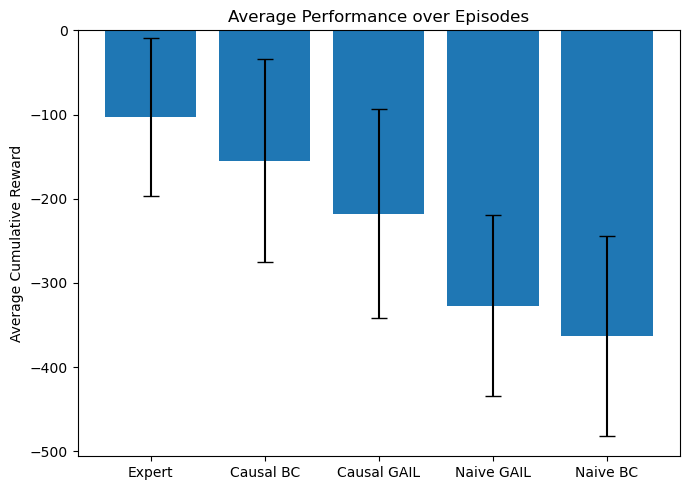

In [60]:
# compute averages
expert_avg = np.mean(expert_rewards)
causal_bc_avg = np.mean(causal_bc_rewards)
naive_bc_avg  = np.mean(naive_bc_rewards)
causal_gail_avg = np.mean(causal_gail_rewards)
naive_gail_avg  = np.mean(naive_gail_rewards)

# compute standard errors (optional but recommended)
expert_std = np.std(expert_rewards)
causal_bc_std = np.std(causal_bc_rewards)
naive_bc_std = np.std(naive_bc_rewards)
causal_gail_std = np.std(causal_gail_rewards)
naive_gail_std = np.std(naive_gail_rewards)

labels = ['Expert', 'Causal BC', 'Naive BC', 'Causal GAIL', 'Naive GAIL']
averages = [expert_avg, causal_bc_avg, naive_bc_avg, causal_gail_avg, naive_gail_avg]
errors = [expert_std, causal_bc_std, naive_bc_std, causal_gail_std, naive_gail_std]

sorted_data = sorted(zip(averages, errors, labels), reverse=True)
averages, errors, labels = map(list, zip(*sorted_data))

plt.figure(figsize=(7,5))
plt.bar(labels, averages, yerr=errors, capsize=6)
plt.ylabel('Average Cumulative Reward')
plt.title('Average Performance over Episodes')
plt.tight_layout()
plt.show()

In [58]:
len(records), len(causal_bc_records), len(naive_bc_records), len(causal_gail_records), len(naive_gail_records)

(115826, 172632, 300000, 229928, 300000)

In [59]:
sum(expert_rewards)/num_eps, sum(causal_bc_rewards)/num_eps, sum(naive_bc_rewards)/num_eps, sum(causal_gail_rewards)/num_eps, sum(naive_gail_rewards)/num_eps

(-103.3189343013503,
 -154.6187898193648,
 -363.1443006261391,
 -217.8453753261944,
 -326.9056725646652)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm

def get_episode_xy_from_records(records, episode_id: int):
    '''
    records: list of dicts from collect_expert_trajectories(...)
    episode_id: which episode to extract

    Returns:
        xs, ys : np.ndarray of shape (T,)
    '''
    # Filter records for that episode, sorted by step
    ep = [r for r in records if r['episode'] == episode_id]
    ep = sorted(ep, key=lambda r: r['step'])

    xs, ys = [], []
    for r in ep:
        # r['info']['hidden_obs']['P'] is a *history* list; last entry is current position
        pos = r['obs']['P'][-1]   # shape (3,)
        xs.append(pos[0])
        ys.append(pos[1])

    return np.array(xs), np.array(ys)

def plot_ant_trajectory_xy(records, episode_id: int = 0, ax=None, title_prefix='AntMaze'):
    '''
    Visualize the ant's 2D trajectory (x, y) for a single episode.

    - Path is colored by time (early=dark, late=bright).
    - Start and end are annotated.
    - Small arrows show direction every few steps.
    '''
    xs, ys = get_episode_xy_from_records(records, episode_id)
    T = len(xs)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    # Build a colored line collection for the path
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Time as color (0..1)
    t_norm = np.linspace(0, 1, T-1)
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1))
    lc.set_array(t_norm)
    lc.set_linewidth(2.5)
    ax.add_collection(lc)

    # Start and end markers
    ax.scatter(xs[0], xs[0], alpha=0)  # dummy to keep colors aligned if needed
    ax.scatter(xs[0], ys[0], s=80, c='green', marker='o', edgecolors='black', label='Start')
    ax.scatter(xs[-1], ys[-1], s=80, c='red', marker='X', edgecolors='black', label='End')

    # Small arrows every N steps to show direction
    step = max(1, T // 30)  # about ~30 arrows max
    for i in range(0, T-1, step):
        dx = xs[i+1] - xs[i]
        dy = ys[i+1] - ys[i]
        ax.arrow(xs[i], ys[i], dx, dy,
                 length_includes_head=True,
                 head_width=0.2,
                 head_length=0.4,
                 alpha=0.6)

    # Colorbar for time
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Time (normalized)')

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.set_title(f'{title_prefix} - Episode {episode_id} trajectory')
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")

    plt.tight_layout()
    return fig, ax

In [30]:
i = 0

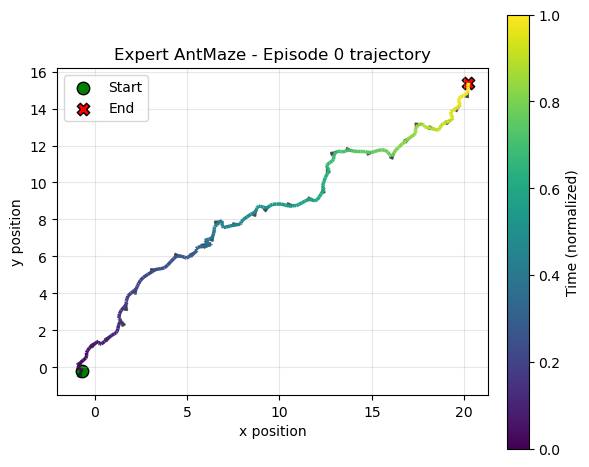

In [31]:
fig, ax = plot_ant_trajectory_xy(records, episode_id=i % num_eps, title_prefix='Expert AntMaze')
plt.show()
i += 1

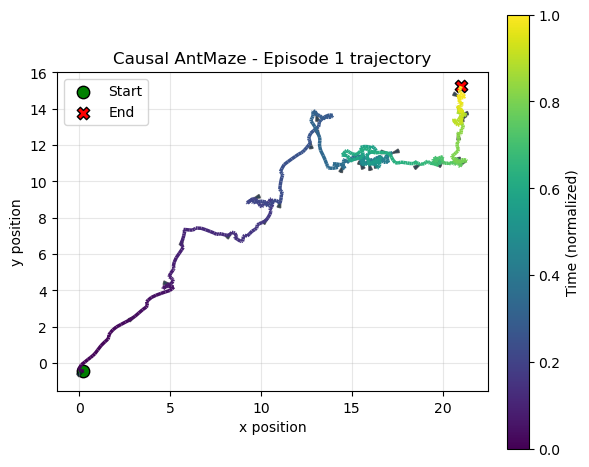

In [32]:
fig, ax = plot_ant_trajectory_xy(causal_gail_records, episode_id=i % num_eps, title_prefix='Causal AntMaze')
plt.show()
i += 1

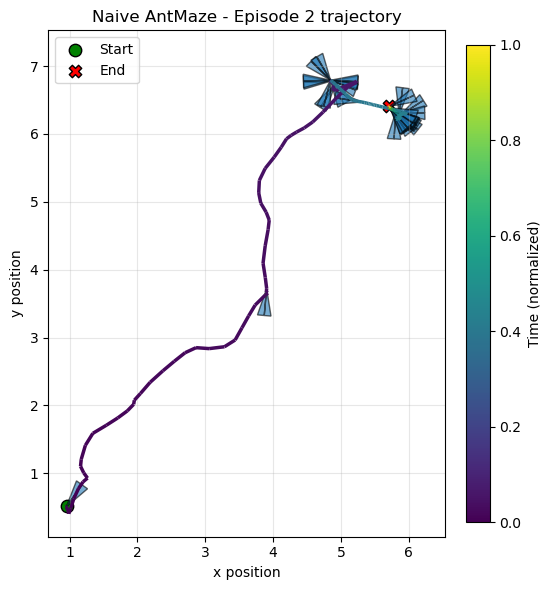

In [33]:
fig, ax = plot_ant_trajectory_xy(naive_gail_records, episode_id=i % num_eps, title_prefix='Naive AntMaze')
plt.show()
i += 1